In [85]:
# data, system tools
import pandas as pd
import numpy as np
import os
import glob
import itertools

# multiprocessing
import multiprocessing as mp
from functools import partial

# stats
from statsmodels.stats import outliers_influence
import statsmodels.stats.multitest as multi
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statannot
import scipy
import scipy.stats

# plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [86]:
data_long = pd.read_csv('../data/final_data/AHEAD_and_CRUISE_and_ICV-combined-long.csv')
data_long = data_long.loc[data_long.Measure.isin(['IQR_intensity', 'Median_intensity', 'Volume'])]
data_long['Statistic'] = data_long.Measure.apply(lambda x: x.split('_')[0])
data_long = data_long.loc[data_long.Intensity.isin(['iron', 'myelin', 'thickness', 'seg'])]
data_long = data_long.loc[~data_long.ROI2.isin(['Cerebellum', 'Cortex'])]
data_long

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
3,iron,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.993294,STR,L,GM,IQR
4,myelin,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,2.239665,STR,L,GM,IQR
9,thickness,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.882512,STR,L,GM,IQR
10,iron,Median_intensity,sub-000,22.0,f,1408505.6,STR L,6.483377,STR,L,GM,Median
11,myelin,Median_intensity,sub-000,22.0,f,1408505.6,STR L,7.133925,STR,L,GM,Median
...,...,...,...,...,...,...,...,...,...,...,...,...
78106,iron,Median_intensity,sub-109,23.0,f,1363826.2,CL R,2.232976,CL,R,GM,Median
78107,myelin,Median_intensity,sub-109,23.0,f,1363826.2,CL R,8.257752,CL,R,GM,Median
78112,thickness,Median_intensity,sub-109,23.0,f,1363826.2,CL R,2.304476,CL,R,GM,Median
78113,seg,Volume,sub-109,23.0,f,1363826.2,CL R,998.932480,CL,R,GM,Volume


In [87]:
data_long = data_long.sort_values(['Measure', 'Segmentation', 'Intensity', 'ROI'])
data_long.ROI.unique()

array(['3V', '4V', 'AMG L', 'AMG R', 'CL L', 'CL R', 'GPe L', 'GPe R',
       'GPi L', 'GPi R', 'LV L', 'LV R', 'PAG L', 'PAG R', 'PPN L',
       'PPN R', 'RN L', 'RN R', 'SN L', 'SN R', 'STN L', 'STN R', 'STR L',
       'STR R', 'THA L', 'THA R', 'VTA L', 'VTA R', 'fx', 'ic L', 'ic R'],
      dtype=object)

## Final version

In [88]:
ROI_order = ['AMG L', 'AMG R', 
             'CL L', 'CL R', 
             'fx',
             'GPe L', 'GPe R',
             'GPi L', 'GPi R',
             'ic L', 'ic R',
             'PAG L', 'PAG R',
             'PPN L', 'PPN R',
             'RN L', 'RN R',
             'SN L', 'SN R',
             'STN L', 'STN R',
             'STR L', 'STR R',
             'THA L', 'THA R',
             'VTA L', 'VTA R',
             'LV L', 'LV R',
             '3V', '4V',
             ]

In [89]:
def bootstrap(data, n_iter=10000):
    all_out = []
    for i in range(n_iter):
        sample = np.random.choice(data, size=data.shape[0], replace=True)
        all_out.append(np.median(sample))
        
    return np.array(all_out)

def get_median_ci(data, n_iter=10000):
    bootstrap_iters = bootstrap(data, n_iter=n_iter)
    return np.array([np.percentile(bootstrap_iters, 2.5), np.percentile(bootstrap_iters, 97.5)])

In [90]:
CIs = data_long.groupby(['ROI', 'Intensity', 'Statistic'])['Value'].apply(lambda x: get_median_ci(x, 10000))
medians = data_long.groupby(['ROI', 'Intensity', 'Statistic'])['Value'].apply(lambda x: np.median(x))

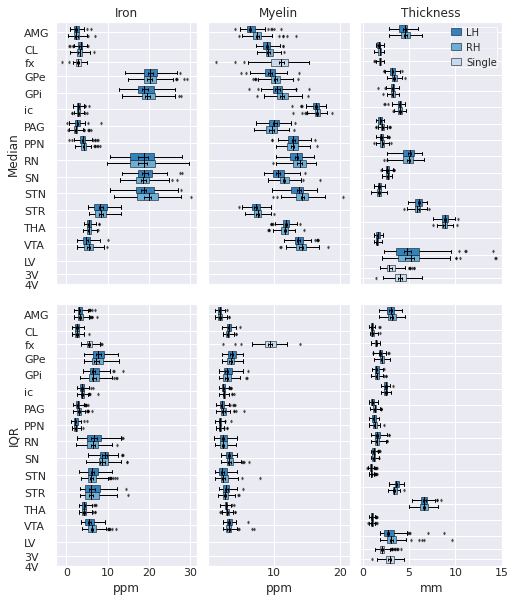

In [91]:
### Error bars
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.26
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.26
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            errbars = np.abs(CIs-medians).loc[ROI,intensity,statistic]
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, bootstrap=1000, 
                                          boxprops={'linewidth':0.5}, positions=[position], 
                                          patch_artist = True, widths=[width], vert=False, zorder=1)
            ax[ax_x, ax_y].errorbar(x=medians.loc[ROI,intensity,statistic], y=position, xerr=errbars[:,np.newaxis], 
                                    linewidth=1, color='black', linestyle='--', capsize=width*3, zorder=2)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
            

        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v6_massp2.pdf', bbox_inches='tight')

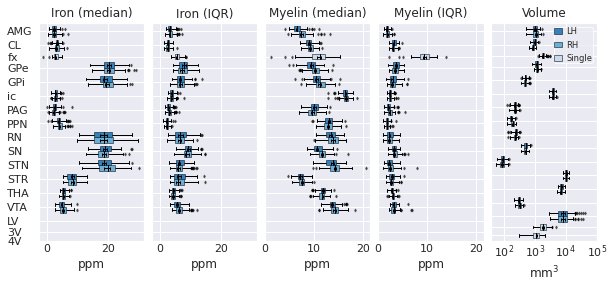

In [92]:
### Error bars
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(1,5, figsize=(10,4), sharey=False, gridspec_kw={'wspace': 0.075, 'hspace': 0.075})
ax = ax[np.newaxis,:]


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'seg']):
    ax_y *= 2
    if intensity == 'seg':
        statistics = ['Volume']
    else:
        statistics = ['Median', 'IQR']
    
    for ax_x, statistic in enumerate(statistics):
        ax_y += ax_x
        ax_x = 0
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.26
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.26
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'seg':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            errbars = np.abs(CIs-medians).loc[ROI,intensity,statistic]
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, bootstrap=1000, 
                                          boxprops={'linewidth':0.5}, positions=[position], 
                                          patch_artist = True, widths=[width], vert=False, zorder=1)
            ax[ax_x, ax_y].errorbar(x=medians.loc[ROI,intensity,statistic], y=position, xerr=errbars[:,np.newaxis], 
                                    linewidth=1, color='black', linestyle='--', capsize=width*3, zorder=2)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
            

        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
#            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
#        if ax_y == 4:
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-3)
#        else:
#            ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-2)
#         ax[ax_x,ax_y].ticklabel_format(useOffsetbool=False) #axis='both', which='major', pad=-3)

        ax[ax_x,ax_y].invert_yaxis()

        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 0:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm$^3$'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,-1].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='x-small')
# sns.despine()
ax[0,2].set_xlim([0,ax[0,2].get_xlim()[1]])
ax[0,-1].set_xscale('log')
ax[0,-1].set_title('Volume')

ax[0,1].sharex(ax[0,0])
ax[0,3].sharex(ax[0,2])
ax[0,-1].set_xticks([1e2, 1e3, 1e4, 1e5])
#

ax[0,0].set_title('Iron (median)')
ax[0,1].set_title('Iron (IQR)')
ax[0,2].set_title('Myelin (median)')
ax[0,3].set_title('Myelin (IQR)')

plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

# yax = ax[1,0].get_yaxis()
# # find the maximum width of the label on the major ticks
# pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
# yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v7_massp2.pdf', bbox_inches='tight')

##### old stuff below

## Early attempts

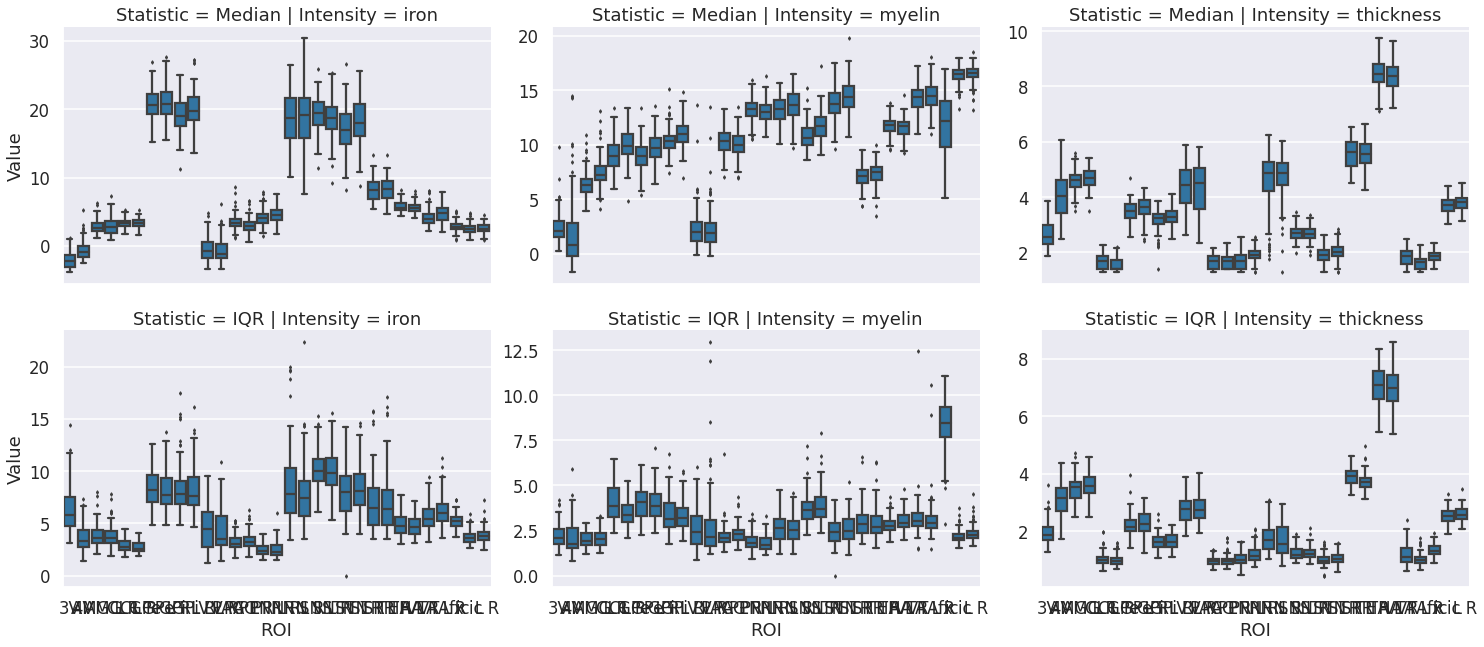

In [107]:
width = 7
aspect = 1.5
sns.set_context('talk')
fac = sns.FacetGrid(data=data_long, col='Intensity', row='Statistic', row_order=['Median', 'IQR'], 
                    sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
# fac.map(plt.axhline, y=0, linestyle='--')
fac.map(sns.boxplot, 'ROI', 'Value', fliersize=2.5, order=data_long['ROI'].unique())

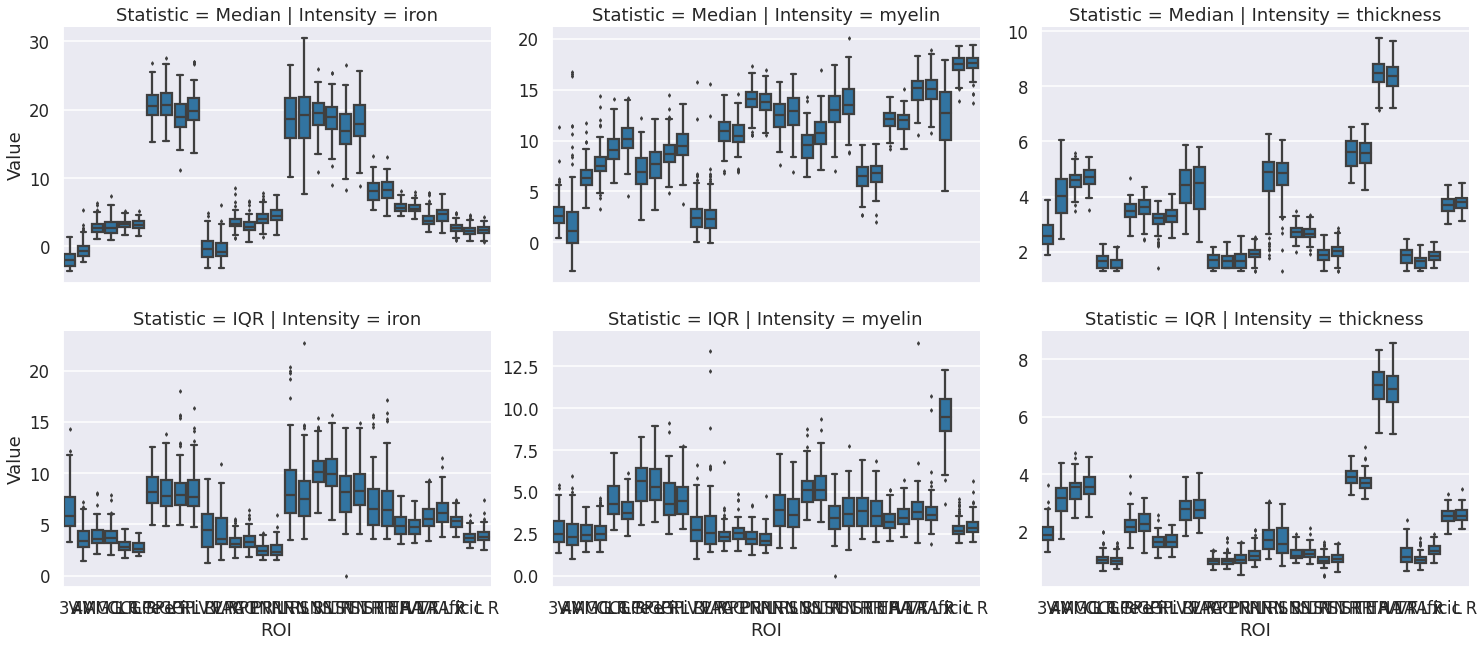

In [52]:
# OLD
width = 7
aspect = 1.5
sns.set_context('talk')
fac = sns.FacetGrid(data=data_long, col='Intensity', row='Statistic', row_order=['Median', 'IQR'], 
                    sharex=True, sharey=False, height=width/aspect, aspect=aspect, despine=True)
# fac.map(plt.axhline, y=0, linestyle='--')
fac.map(sns.boxplot, 'ROI', 'Value', fliersize=2.5, order=data_long['ROI'].unique())

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1218: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1226: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning:

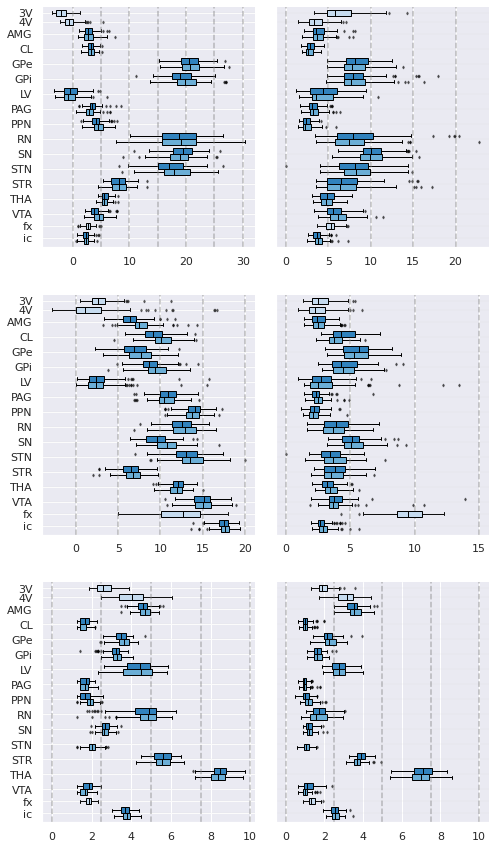

In [53]:
sns.set_context('notebook')
f, ax = plt.subplots(3,2, figsize=(8,15), sharey=False, sharex=False, gridspec_kw={'wspace': 0.1})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5

for ax_n, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_y, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if 'VENT' in ROI and not intensity == 'thickness':
                continue
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
#             bps[intensity][statistic]['f'].append(ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False))

    #         # M
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='m'), 'Value']
    #         bps[intensity][statistic]['m'].append(ax[ax_n].boxplot(values, notch=False, positions=[position+width/2], patch_artist = True, widths=[width/2]))

        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels(labelpos.index)
        if ax_y == 1:
            ax[ax_n,ax_y].set_yticks([])
            ax[ax_n,ax_y].set_yticklabels([])
        _ = [ax[ax_n,ax_y].axhline(x, alpha=0.1, color='lightgrey') for x in labelpos]

        if intensity == 'iron':
            if statistic == 'IQR':
                lines = np.arange(0,21,5)
            else:
                lines = np.arange(0,31,5)
        elif intensity == 'myelin':
            if statistic == 'IQR':
                lines = np.arange(0,16,5)
            else:
                lines = np.arange(0,21,5)
        else:
            lines = np.arange(0,11,2.5)
        
        _ = [ax[ax_n,ax_y].axvline(x, color='grey', linestyle = '--', alpha = 0.5) for x in lines]
        ax[ax_n,ax_y].invert_yaxis()

sns.despine()
# f.savefig('../figures/boxplots_test.pdf', bbox_inches='tight')

## Label in center?

/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1218: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1226: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning:

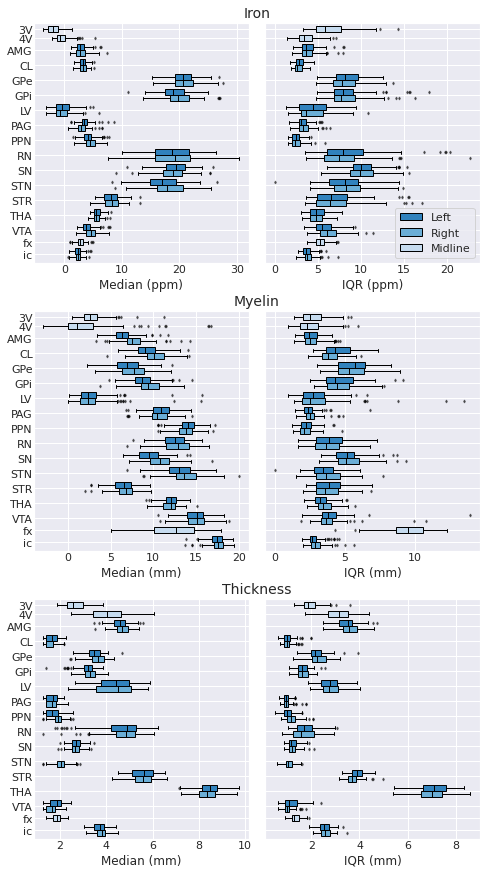

In [54]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(3,2, figsize=(8,15), sharey=False, sharex=False, gridspec_kw={'wspace': 0.075})

cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_n, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_y, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if 'VENT' in ROI and not intensity == 'thickness':
                continue
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_n,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels(labelpos.index)
        if ax_y == 1:
            ax[ax_n,ax_y].set_yticks(labelpos)
            ax[ax_n,ax_y].set_yticklabels([])
        ax[ax_n,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_n,ax_y].invert_yaxis()
        
        # Axis labels
        unit = 'ppm' if intensity in ['iron', 'median'] else 'mm'
        ax[ax_n, ax_y].set_xlabel('{} ({})'.format(statistic, unit))
        
        # add subplot with title
        if(ax_y == 0):
            ax_ = f.add_subplot(3,1,ax_n+1)
            ax_.axis('off')
            ax_.set_title(intensity.capitalize(), fontdict={'fontsize': 14})

ax[0,1].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], ['Left', 'Right', 'Midline'])
# sns.despine()
# f.savefig('../figures/boxplots_test2.pdf', bbox_inches='tight')

## one final shot at horizontal?


/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1218: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1226: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/home/stevenm/.conda/envs/python3/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning:

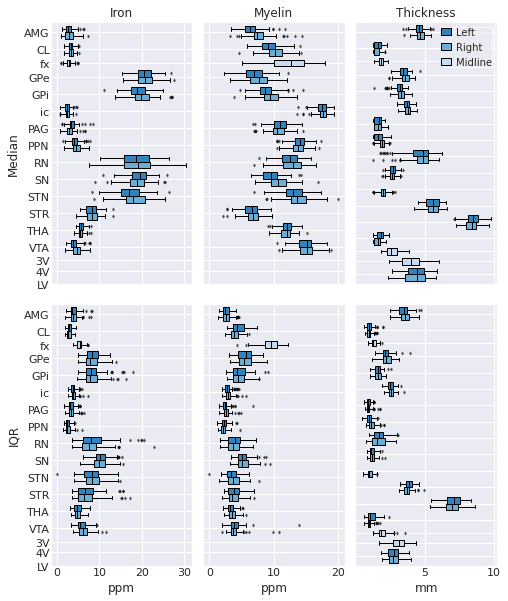

In [25]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if 'VENT' in ROI and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index)
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
        
#         # add subplot with title
#         if(ax_n == 0):
#             ax_ = f.add_subplot(3,1,ax_n+1)
#             ax_.axis('off')
#             ax_.set_title(intensity.capitalize(), fontdict={'fontsize': 14})

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['Left', 'Right', 'Midline'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()

# f.savefig('../figures/figure1_boxplots_v3.pdf', bbox_inches='tight')

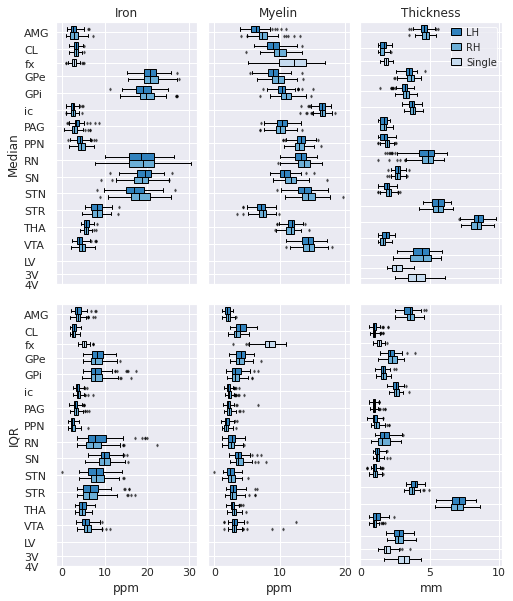

In [6]:
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v4.pdf', bbox_inches='tight')

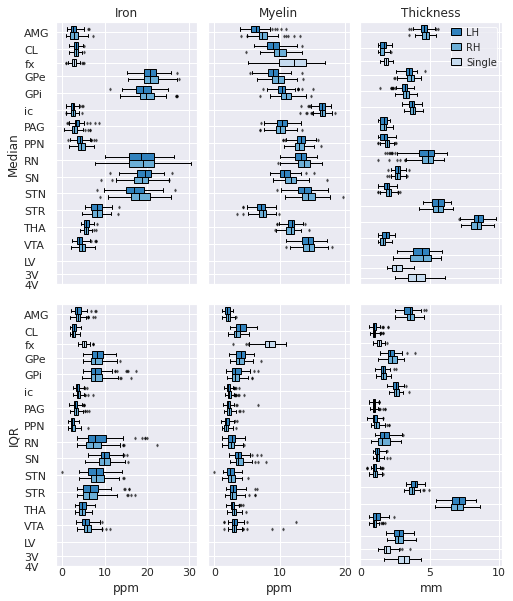

In [7]:
###
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(2,3, figsize=(8,10), sharey=False, sharex='col', gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['iron', 'myelin', 'thickness']):
    for ax_x, statistic in enumerate(['Median', 'IQR']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
            if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
                continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
               ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
               labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

f.savefig('../figures/figure1_boxplots_v5.pdf', bbox_inches='tight')

## New table with volumes

In [3]:
demo = pd.read_csv('../data/source_data/ahead_demographics.csv', sep=';')
demo = demo.loc[pd.notnull(demo['ScanName'])]
demo['Segmentation'] = demo['ScanName'].apply(lambda x: 'sub-' + x[-3:])
demo.head()


data = pd.read_csv('../data/source_data/fcm/ahead-31struct-qmri2fcm-final-thickness-statistics.csv')
# data = pd.concat(data)
col_names = ['STR L', 'STR R',
             'STN L', 'STN R',
             'SN L', 'SN R',
             'RN L', 'RN R',
             'GPi L', 'GPi R',
             'GPe L', 'GPe R',
             'THA L', 'THA R',
             'LV L', 'LV R',
             '3V', '4V',
             'AMG L', 'AMG R',
             'ic L', 'ic R',
             'VTA L', 'VTA R',
             'fx',
             'PAG L', 'PAG R',
             'PPN L', 'PPN R',
             'CL L', 'CL R']

data.columns = ['Measure', 'Segmentation', 'Template', 'Intensity'] + col_names
data['Segmentation'] = data['Segmentation'].apply(lambda x: x.split('_')[0])
data = data.loc[data['Segmentation'] != 'sub-070']  # subject was dropped due to data quality issues
del data['Template']

# ICV
icv = pd.read_csv('../data/source_data/ahead-qmr2-icv-statistics.csv')
del icv['Template']
del icv['Intensity']
icv['Segmentation'] = icv['Segmentation'].apply(lambda x: x.split('_')[0])
whole_brain_volume = icv.rename(columns={'Label_1': 'icv'})

# merge subcortex data with demographics
data = pd.merge(data, demo[['Sexe', 'Age', 'Segmentation']], on='Segmentation')
data = data.sort_values(['Measure', 'Segmentation', 'Intensity'])
data.head()

# Merge with volume
data = pd.merge(data, whole_brain_volume.loc[whole_brain_volume.Measure=='Volume',['Segmentation', 'icv']])

# coerce to float
for col in col_names:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data['Intensity'] = 'seg'

structs = []
for col in data.columns:
    if col in ['Measure', 'Intensity', 'Segmentation', 'Age', 'Sexe', 'icv']:
        continue
    data[col] = data[col].astype(float)
    structs.append(col)

ahead_volumes = data.melt(id_vars=['Intensity', 'Measure', "Segmentation", 'Age', 'Sexe', 'icv'],
                          value_vars=structs, value_name='Value', var_name='ROI')
ahead_volumes['ROI2'] = ahead_volumes['ROI'].str.split(' ').apply(lambda x: x[0])
# ahead_long.loc['ROI2'] = ahead_long['ROI'].str.split(' ').apply(lambda x: x[0])

ahead_volumes['hemisphere'] = ahead_volumes['ROI'].str.split(' ').apply(lambda x: x[1] if len(x)>1 else 'X')
ahead_volumes['tissue_type'] = ahead_volumes['ROI2'].map({'STR': 'GM',
                                                    'STN': 'GM',
                                                    'SN': 'GM',
                                                    'RN': 'GM',
                                                    'GPi': 'GM',
                                                    'GPe': 'GM',
                                                    'THA': 'GM',
                                                    'LV': 'CSF',
                                                    'AMG': 'GM',
                                                    'ic': 'WM',
                                                    'VTA': 'GM',
                                                    'fx': 'WM',
                                                    'PAG': 'GM',
                                                    'PPN': 'GM',
                                                    'ICO': 'GM',
                                                    'SCO': 'GM',
                                                    'CL': 'GM',
                                                    'Cortex': 'GM',
                                                    'Cerebellum': 'GM'})

ahead_volumes['Statistic'] = ahead_volumes['Measure'].replace({'IQR_intensity': 'iqr', 'Median_intensity': 'median', 'Volume': 'voxels'})

ahead_volumes.head()

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
0,seg,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.882512,STR,L,GM,iqr
1,seg,Median_intensity,sub-000,22.0,f,1408505.6,STR L,5.859861,STR,L,GM,median
2,seg,Volume,sub-000,22.0,f,1408505.6,STR L,10197.734000,STR,L,GM,voxels
3,seg,IQR_intensity,sub-001,23.0,m,1564215.2,STR L,3.578887,STR,L,GM,iqr
4,seg,Median_intensity,sub-001,23.0,m,1564215.2,STR L,6.735042,STR,L,GM,median


In [4]:
data_long = ahead_volumes.copy()

In [10]:
statistic

'IQR_intensity'

In [12]:
data_long

,Intensity,Measure,Segmentation,Age,Sexe,icv,ROI,Value,ROI2,hemisphere,tissue_type,Statistic
0,seg,IQR_intensity,sub-000,22.0,f,1408505.6,STR L,3.882512,STR,L,GM,iqr
1,seg,Median_intensity,sub-000,22.0,f,1408505.6,STR L,5.859861,STR,L,GM,median
2,seg,Volume,sub-000,22.0,f,1408505.6,STR L,10197.734000,STR,L,GM,voxels
3,seg,IQR_intensity,sub-001,23.0,m,1564215.2,STR L,3.578887,STR,L,GM,iqr
4,seg,Median_intensity,sub-001,23.0,m,1564215.2,STR L,6.735042,STR,L,GM,median
...,...,...,...,...,...,...,...,...,...,...,...,...
9760,seg,Median_intensity,sub-108,23.0,m,1294834.0,CL R,2.159126,CL,R,GM,median
9761,seg,Volume,sub-108,23.0,m,1294834.0,CL R,868.027040,CL,R,GM,voxels
9762,seg,IQR_intensity,sub-109,23.0,f,1363826.2,CL R,1.399997,CL,R,GM,iqr
9763,seg,Median_intensity,sub-109,23.0,f,1363826.2,CL R,2.304476,CL,R,GM,median


In [19]:
ax_y

0

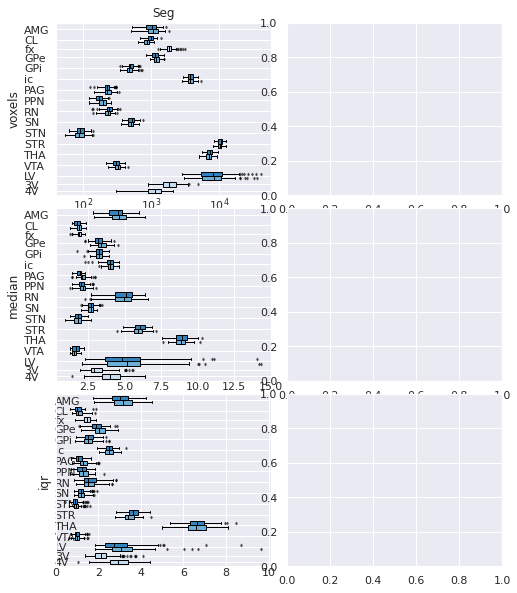

In [24]:
###
sns.set_style("darkgrid")
sns.set_context('notebook')
f, ax = plt.subplots(3,2, figsize=(8,10), sharey=False, sharex=False, gridspec_kw={'wspace': 0.075, 'hspace': 0.075})


cmap = plt.get_cmap('tab20c')
norm = matplotlib.colors.Normalize(vmin=0,vmax=20)

intensity = 'iron'
statistic = 'Median'

width = .5
artists_for_legend = []

for ax_y, intensity in enumerate(['seg']):
    for ax_x, statistic in enumerate(['voxels', 'median', 'iqr']):
        bps = {intensity: {statistic: {'f': [], 'm': []}}}

        all_positions = {}
        position = 0
        for i, ROI in enumerate(ROI_order): #enumerate(data_long.ROI.unique()):
            if ROI.endswith(' L'):
                position += width+.25
                color = cmap(norm(0))
            elif ROI.endswith(' R'):
                position += width
                color = cmap(norm(1))
            else:
                position += width+.25
                color = cmap(norm(3))
            all_positions[ROI] = position
            
#             if ('LV ' in ROI or '3V' in ROI or '4V' in ROI) and not intensity == 'thickness':
#                 continue

            # F
    #         values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic) & (data_long['Sexe']=='f'), 'Value']
            values = data_long.loc[(data_long['ROI'] == ROI) & (data_long['Intensity'] == intensity) & (data_long['Statistic'] == statistic), 'Value']
            values = values[pd.notnull(values)]  # one observation has no median thickness for STN L
            bplot = ax[ax_x,ax_y].boxplot(values, notch=False, positions=[position], patch_artist = True, widths=[width], vert=False)
            for patch in bplot['boxes']:
                patch.set_facecolor(color)

            for flier in bplot['fliers']: 
                flier.set(marker ='d', 
                          color ='black', 
                          alpha = .5,
                          markerfacecolor='k',
                          markersize = 2) 

            for median in bplot['medians']: 
                median.set(color ='black', linewidth = 1) 
                
            if ROI.endswith( 'L'):
                if len(artists_for_legend) == 0:
                    artists_for_legend.append(bplot)
            elif ROI.endswith(' R'):
                if len(artists_for_legend) == 1:
                    artists_for_legend.append(bplot)
            else:
                if len(artists_for_legend) == 2:
                    artists_for_legend.append(bplot)
        
        # Ticks, ticklabels
        positions = pd.DataFrame(pd.Series(all_positions)).reset_index()
        positions.columns = ['ROI', 'position']
        positions['ROI2'] = positions['ROI'].apply(lambda x: x.split(' ')[0] if ' ' in x else x)
        positions['Hemi'] = positions['ROI'].apply(lambda x: x.split(' ')[1] if ' ' in x else '')
        labelpos = positions.groupby('ROI2').position.mean()
        
        if ax_y == 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels(labelpos.index, ha = 'left')
            ax[ax_x,ax_y].set_ylabel(statistic)
        if ax_y > 0:
            ax[ax_x,ax_y].set_yticks(labelpos)
            ax[ax_x,ax_y].set_yticklabels([])
        ax[ax_x,ax_y].tick_params(axis='both', which='major', pad=-5)
        ax[ax_x,ax_y].invert_yaxis()
        
        if ax_x == 0:
            ax[ax_x,ax_y].set_title(intensity.capitalize()) #, fontdict={'fontsize': 14})

        # Axis labels
        if ax_x == 1:
            unit = 'ppm' if intensity in ['iron', 'myelin'] else 'mm'
            ax[ax_x, ax_y].set_xlabel('{}'.format(unit))
            

# ax[0,2].legend([artists_for_legend[0]['boxes'][0], artists_for_legend[1]['boxes'][0], artists_for_legend[2]['boxes'][0]], 
#                ['LH', 'RH', 'Single'], borderaxespad=.5, borderpad=0,
#                labelspacing=.5, handlelength=1, handletextpad=0.5, edgecolor='white', fontsize='small')
# sns.despine()


ax[0,0].set_xscale('log')

plt.draw()  # this is needed because get_window_extent needs a renderer to work
yax = ax[0,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

yax = ax[1,0].get_yaxis()
# find the maximum width of the label on the major ticks
pad = max(T.label.get_window_extent().width for T in yax.majorTicks)
yax.set_tick_params(pad=pad)

# f.savefig('../figures/figure1_boxplots_v5.pdf', bbox_inches='tight')